In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pylab as pl
import numpy as np

In [2]:
class Net(nn.Module):
    """Implements a MLP with 4 layers of 64 neurons each and relu activation, one input and two outputs"""
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.silu(self.fc1(x))
        x = F.silu(self.fc2(x))
        x = F.silu(self.fc3(x))
        x = self.fc4(x)
        return x


def train(model: nn.Module, device, X, y, criterion, optimizer, epochs):
    model.train()
    data, target = X.to(device), y.to(device)
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

In [3]:
def output_to_params(output):
    mu, sigma = output[:, 0], F.softplus(output[:, 1]) + 1e-8
    return mu, sigma

def criterion(output, target):
    mu, sigma = output_to_params(output)
    return torch.mean(0.5 * ((mu - target) / sigma) ** 2 + torch.log(sigma))

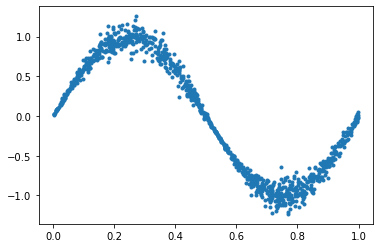

In [28]:
def noise(x, noise_level=0.1):
    n_points = x.shape[0]
    return torch.randn(n_points) * torch.sin(torch.linspace(0, 6, n_points)) * noise_level

def generate_data(n_points, noise=noise, frequency=1):
    X, _ = torch.sort(torch.rand(n_points))
    y = torch.sin(frequency * X) + noise(X)
    return X.unsqueeze_(1), y

X, y = generate_data(1024, frequency=2*np.pi)
pl.plot(X[:, 0].numpy(), y.numpy(), '.')

In [29]:
def plot_predictions(model, X, y):
    model.eval()
    with torch.no_grad():
        x, y = X[:, 0].numpy(), y.numpy()
        mu, sigma = output_to_params(model(X))

        pl.plot(x, y, '.')
        pl.plot(x, mu)
        pl.fill_between(x, mu - sigma, mu + sigma, alpha=0.5)

def get_residuals(model, X, y):
    model.eval()
    with torch.no_grad():
        x, y = X[:, 0].numpy(), y.numpy()
        mu, sigma = output_to_params(model(X))

        return (y - mu.numpy()) / sigma.numpy()

def plot_residuals(model, X, y):
    pl.plot(X[:, 0], get_residuals(model, X, y), '.')

In [30]:
model = Net()

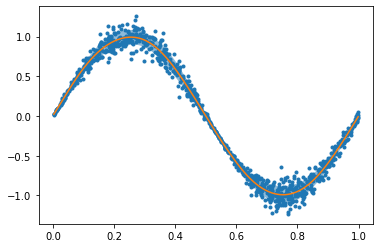

In [43]:
train(model, torch.device("cpu"), X, y, criterion, torch.optim.Adam(model.parameters(), lr=1e-3), epochs=1000)
plot_predictions(model, X, y)

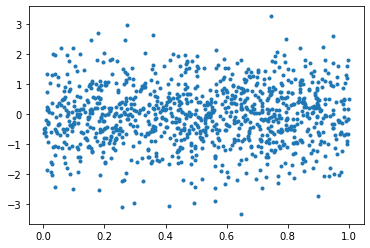

In [44]:
plot_residuals(model, X, y)

(array([  3.,   4.,   6.,  19.,  20.,  49.,  59.,  90., 128., 134., 143.,
        124.,  79.,  69.,  45.,  29.,  15.,   3.,   3.,   2.]),
 array([-3.3179612 , -2.988509  , -2.6590567 , -2.3296044 , -2.000152  ,
        -1.6706997 , -1.3412474 , -1.0117952 , -0.6823428 , -0.35289052,
        -0.02343822,  0.3060141 ,  0.6354664 ,  0.9649187 ,  1.294371  ,
         1.6238233 ,  1.9532756 ,  2.282728  ,  2.6121802 ,  2.9416325 ,
         3.2710848 ], dtype=float32),
 <BarContainer object of 20 artists>)

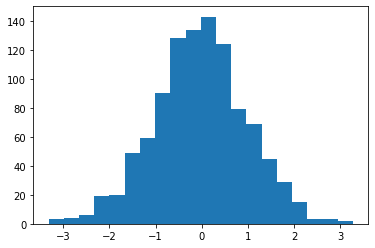

In [48]:
pl.hist(get_residuals(model, X, y), bins=20)